# Cohort Analysis - Retention Rate, Revenue, and Behaviour using Pandas
In this notebook, I will explore some sample user data from a mobile app and extract conclusions based on their behaviour.

The data contains the following information:<br>
• user_id - user identifier;<br>
• event_date - time of the event;<br>
• event_type - type of event;<br>
• purchase_amount - purchase amount.

Ultimately, I want to find how retention rate (RR) changes over time, and what the average revenue is per paying user (ARPPU).

In [66]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

### Import and Prep the Data
This dataset was provided by Yandex Open Data.

In [67]:
df = pd.read_csv('event_data.csv',parse_dates=True)
df.head()

,user_id,event_date,event_type,purchase_amount
0,c40e6a,2019-07-29 00:02:15,registration,NaN
1,a2b682,2019-07-29 00:04:46,registration,NaN
2,9ac888,2019-07-29 00:13:22,registration,NaN
3,93ff22,2019-07-29 00:16:47,registration,NaN
4,65ef85,2019-07-29 00:19:23,registration,NaN


To calculate how RR changes over time, first we need to assign each registered user a cohort based on their registration date. I will break them into weekly groups.

In addition, I will add a column to indicate the age of the cohort (in weeks) for every event.

In [68]:
# Convert event_date column to date time and extract week number
df['event_date'] = pd.to_datetime(df['event_date'])
df['event_date_week'] = df.event_date.dt.isocalendar().week

# Isolate registration event per user and merge tables
df_reg = df[df.event_type == 'registration']
df_reg = df_reg[['user_id', 'event_date_week']]
df_reg.columns = ['user_id', 'cohort_id']
df = pd.merge(df,df_reg, how='left')

# Calculate age of cohort at every event
df['cohort_lifetime'] = df.event_date_week - df.cohort_id


print(df.head())

  user_id          event_date    event_type  purchase_amount  event_date_week  \
0  c40e6a 2019-07-29 00:02:15  registration              NaN               31   
1  a2b682 2019-07-29 00:04:46  registration              NaN               31   
2  9ac888 2019-07-29 00:13:22  registration              NaN               31   
3  93ff22 2019-07-29 00:16:47  registration              NaN               31   
4  65ef85 2019-07-29 00:19:23  registration              NaN               31   

   cohort_id  cohort_lifetime  
0         31                0  
1         31                0  
2         31                0  
3         31                0  
4         31                0  


Next, I will create a pivot table in order to show how many unique user IDs we have for each week of a specific cohort.

In [69]:
cohorts = df.pivot_table(index = ['cohort_id','cohort_lifetime'], 
                         aggfunc = {'user_id':'nunique'}).reset_index() 

In [70]:
cohorts

,cohort_id,cohort_lifetime,user_id
0,31,0,1975
1,31,1,1832
2,31,2,1243
3,31,3,705
4,31,4,297
5,32,0,1952
6,32,1,1814
7,32,2,1265
8,32,3,705
9,33,0,2045


### Calculating Retention Rate
Retention rate is the measure of customer retention or the percentage of people who remain customers after some time. It is calcluated as:

Retention Rate = (Number of customers at the end of a specific period) / (Number of customers who registered at a specific period)

So, to calculate retention rate, we first need to know how many initial users there are per cohort, then we can create a pivot table that shows how retention rate changes over time.

In [71]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0]
initial_users_count = initial_users_count[['cohort_id','user_id']]
initial_users_count = initial_users_count.rename(columns={'user_id':'cohort_users'}) 

In [72]:
initial_users_count

,cohort_id,cohort_users
0,31,1975
5,32,1952
9,33,2045
12,34,1974
14,35,2050


In [73]:
cohorts = cohorts.merge(initial_users_count,on='cohort_id')
cohorts['retention'] = cohorts['user_id']/cohorts['cohort_users'] 
retention_pivot = cohorts.pivot_table(index='cohort_id',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum') 

In [74]:
retention_pivot

cohort_lifetime,0,1,2,3,4
cohort_id,,,,,
31,1.0,0.927595,0.629367,0.356962,0.15038
32,1.0,0.929303,0.648053,0.361168,NaN
33,1.0,0.924205,0.661125,NaN,NaN
34,1.0,0.929078,NaN,NaN,NaN
35,1.0,NaN,NaN,NaN,NaN


### Visualize the Data
In order to get a better visual representation of the data, I will plot a heatmap using Seaborn.

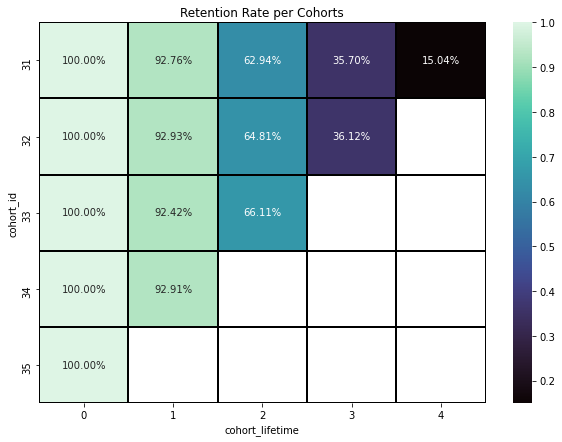

In [75]:
plt.figure(figsize=(10, 7))
plt.title('Retention Rate per Cohorts')
sns.heatmap(retention_pivot, annot=True, 
            fmt='.2%', linewidths=1, 
            cmap= "mako", linecolor='black'); 

As we can see, retention rate remains relatively unchanged throughout any particular cohort, but in all cases usage drops off fairly rapidly. In the cohort for which we have the most data, only 15% of people are still using the app after 4 weeks. Unless this app is only intended for single purchases, this may indicate a serious problem with usability.

### Calculate the Average Revenue Per Paying User

Now I will do a similar process to calculate the Average Revenue Per Paying User (ARPPU) by cohor to see how/if it changes over time

In [76]:
paying_users = df[df['event_type'] == 'purchase']
arppu_pivot = paying_users.pivot_table(index='cohort_id', 
                                       columns='cohort_lifetime', 
                                       values='purchase_amount',
                                      aggfunc='mean')

In [77]:
arppu_pivot

cohort_lifetime,0,1,2,3,4
cohort_id,,,,,
31,28.132911,29.511494,30.525000,29.142857,30.454545
32,30.222841,29.773692,29.928741,29.528302,NaN
33,30.689655,30.519663,29.171975,NaN,NaN
34,30.776699,30.929134,NaN,NaN,NaN
35,30.721925,NaN,NaN,NaN,NaN


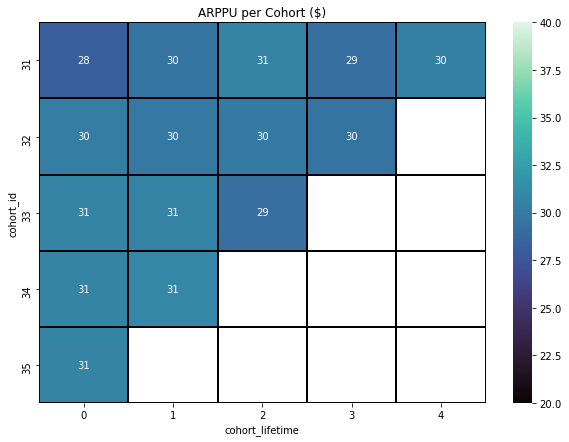

In [78]:
plt.figure(figsize=(10, 7))
plt.title('ARPPU per Cohort ($)')
sns.heatmap(arppu_pivot, label='dollars', 
            vmin=20.0, vmax=40.0,  
            annot=True, robust=True, linewidths=1, 
            cmap="mako",linecolor='black'); 

From the above heatmap, you can clearly see that the ARPPU has minimal variance across all cohorts

### What is the average time between user registration and first purchase?

To understand a little more about user behaviour, below I will calculate the median time between registration and first purchase.

In [97]:
# Get registration data per user_id
registration_date = df[df['event_type']=='registration']
registration_date = registration_date[['user_id', 'event_date']]
registration_date = pd.DataFrame.drop_duplicates(registration_date)
registration_date.columns = ['user_id', 'registration_date']

In [98]:
# Get first purchase date per user_id
first_purchase_date = df[df['event_type']=='purchase']
first_purchase_date = first_purchase_date[['user_id', 'event_date']]
first_purchase_date = pd.DataFrame.drop_duplicates(first_purchase_date)
first_purchase_date.columns = ['user_id', 'first_purchase_date']

In [99]:
# Find delay between registration and purchase
delay_df = pd.merge(registration_date,first_purchase_date, how='inner')
delay_df['purchase_delay'] = median_time_df['first_purchase_date'] - median_time_df['registration_date']

Text(0, 0.5, 'Number of users')

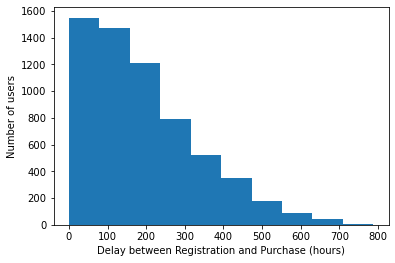

In [100]:
delay_df['purchase_delay'].astype('timedelta64[h]').plot.hist()
plt.xlabel('Delay between Registration and Purchase (hours)')
plt.ylabel('Number of users')

In [101]:
median_time = delay_df['purchase_delay'].median()
print(median_time)

6 days 18:49:30


From the above, we can see that the typical delay between registration and first purchase is almost a week, and that delay times decay exponentially.

## Conclusion

From the data above, we can see that users of this app tend to have a short lifespan, spend on average \\$30 each in total, and have a median delay of almost 7 days between registration and purchase. This information could be useful in informing marketing campaigns to try and boost sales by targeting people with ads in specific timeframes and giving people purchase incentives so they spend more than \\$30

### Thank you!
JE. Collinson